In [1]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from dateutil.relativedelta import relativedelta
import seaborn as sns
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
import datetime

In [2]:
# Directories
MACRO_DIR = '../Data/macro_factors/'
OUTPUT_DIR = '../Outputs/equity/'
CLUSTER_DIR = '../Outputs/country_clusters/'

# Filter by year
start_date = '2015-09-27'
end_date = '2021-01-31'

In [3]:
# Load equity ETF log returns
equity_rets_w = pd.read_pickle(OUTPUT_DIR + 'equity_etf_returns_weekly.pkl')

# Load market returns, i.e., EM Aggregate returns from EEM ETF index
market_rets_w = pd.read_pickle(OUTPUT_DIR + 'equity_EM_agg_market_returns.pkl')

# Load clusters
equity_clusters = pd.read_pickle(CLUSTER_DIR + 'clusters_equity_etf_full.pkl')

# Purpose of Notebook:
Construct similarity measure to determine periods of similar volatility and GDP for each country.

We use adjusted cosine similarity (http://www10.org/cdrom/papers/519/node14.html):
$$
similarity = cos \theta = \frac{A B}{||A|| ||B||}
$$
This measure computes the cosine angle between vectors A, B - in this case, A, B would be today $t$ vs. all periods in the past before $t$, respectively. Note that A and B excludes the mean of both features. A cosine angle of 0 means that the 2 vectors are at 90 degrees to each other (i.e. orthogonal) and have no match. The closer the cosine value is to 1, the smaller the angle and greater the similarity. (Cosine similarity ranges from 0 to 1).

Then, it follows that distances is defined by:
$$
cos distance = 1 / similarity
$$

We would like to **overweight** periods that are similar to today, and **underweight** periods that are not similar to today. 

**Framework:**
1. Construct GDP growth
2. Construct volatility measures
3. Construct total distance measure based on volatility and GDP growth: 2/3 * distance on GDP growth + 1/3 distance on volatility

## 1. GDP Growth

In [4]:
# Load macro data - GDP growth (annual percentage change)
gdp_growth = pd.read_csv(MACRO_DIR + 'EM_GDP_QPCHNG.csv')
gdp_growth = gdp_growth[['LOCATION', 'TIME', 'Value']]
gdp_growth = pd.pivot_table(gdp_growth, values='Value', index=['TIME'], columns='LOCATION').reset_index()
gdp_growth.index = pd.date_range('1961-01', '2021-01', freq='Q')
del gdp_growth['TIME']
del gdp_growth['OECD']

gdp_codes_dict = {'ARG': 'Argentina', 'BRA': 'Brazil', 'CHL':'Chile', 'CHN':'China', 'COL':'Colombia', 'GRC': 'Greece', 'IND':'India', \
                 'KOR': 'Korea', 'MEX': 'Mexico', 'POL': 'Poland', 'RUS':'Russia', 'SAU':'Saudi Arabia', 'TUR': 'Turkey', 'ZAF': 'South Africa'}
gdp_growth.rename(gdp_codes_dict, axis=1, inplace=True)
gdp_growth = gdp_growth[(gdp_growth.index>='2013-01-01') & (gdp_growth.index<=end_date)]
gdp_growth = gdp_growth.fillna(method='ffill').fillna(method='bfill')

#####################################################################################################################################################
# Load macro data - GDP: This file contains raw GDP values for every country; we are missing some GDPs in the dataset above
# So we need to manually calculate annual % change in GDP at every quarter
country_GDP = pd.read_csv(MACRO_DIR + 'world_real_GDP.csv', skiprows=51)
country_GDP_match = pd.read_csv(MACRO_DIR + 'world_real_GDP.csv', nrows=50)
country_GDP_match = country_GDP_match[['Ticker', 'Country']]
country_GDP_dict = country_GDP_match.set_index('Ticker')['Country'].to_dict()
country_GDP_dict = {k+'_Close': v for k, v in country_GDP_dict.items()}

country_GDP.index = country_GDP['Date']
del country_GDP['Date']

# Rename columns
em_countries = equity_rets_w.columns.values
country_GDP.rename(country_GDP_dict, axis=1, inplace=True)
missing_GDP = country_GDP[['Pakistan', 'Egypt', 'Thailand', 'Taiwan', 'Peru', 'Malaysia', 'Philippines']]
missing_GDP = missing_GDP.dropna(how='all')
missing_GDP.index = pd.to_datetime(missing_GDP.index)
missing_GDP = missing_GDP[(missing_GDP.index>='2013-01-01') & (missing_GDP.index<=end_date)]
missing_GDP['Pakistan'] = missing_GDP['Pakistan'].interpolate(method='linear', limit_direction='forward')
missing_GDP_GRO = missing_GDP.pct_change(4)*100

# Combine gdP
gdp_growth_em = pd.concat([gdp_growth, missing_GDP_GRO], axis=1)
gdp_growth_em = gdp_growth_em[(gdp_growth_em.index>='2014-09-30') & (gdp_growth_em.index<=end_date)]
gdp_growth_em = gdp_growth_em.fillna(method='bfill')

#####################################################################################################################################################
# Convert to weekly: NOTE: GDP Growth was in annualized quarterly %, we interpolated this number to weekly, so it's weekly annualized
df_daily = gdp_growth_em.asfreq('D').interpolate(method='polynomial', order=2).dropna()
gdp_growth_em_weekly = df_daily.resample('W').last()

## 2. Volatility
We used rolling past 26-weeks sum of squared returns to obtain realized variance, then realized volatility associated with each country.

In [5]:
equity_vol_w = np.sqrt(np.power(equity_rets_w, 2).rolling(25).sum())
equity_vol_w.dropna(inplace=True)

## 3. Distance Score

In [6]:
def distance_score(df, method='expanding', start=51, window=25):
    '''
    Computes distance score given dataframe of macro data
    + Start: this is the starting month since the beginning of the macro-data 
    as the macro data begins a little before equity returns to allow
    for all scores to be computed / data does not need to be truncated
    + Window: If method = 'rolling', then we use the last 25 weeks' worth of macro data 
    to compute distance score
    Outputs:
    + distances_df: contains distance scores computed from macro data, df
    '''
    estimated_dist_ = []
    dates_ = []
    
    for ii in range(df.shape[0]-start-1):
        current_t = df.iloc[start+ii,:]
        if method == 'expanding':
            previous_t = df.iloc[:start+ii,:]
        else:
            previous_t = df.iloc[window+ii:start+ii,:]

        def calc_distance(current, previous):
            # Find cosine similarity first
            no_mean_current = current - current.mean()
            no_mean_previous = previous - previous.mean()
            cos_sim = np.dot(no_mean_current, no_mean_previous)/(np.linalg.norm(no_mean_current) * np.linalg.norm(no_mean_previous))
            #cos_distance = 1/cos_sim
            return cos_sim

        all_distances = []
        all_dates = []
        for index, row in previous_t.iterrows():
            distance_score = calc_distance(current_t, row)
            all_distances.append(distance_score)
            all_dates.append(row.name)
        all_prev_dist_df = pd.DataFrame(all_distances, index=all_dates)
        all_prev_dist_df.columns = ['Distance']
        all_prev_dist_df['ewm_dist'] = all_prev_dist_df['Distance'].ewm(alpha=0.3,adjust=False).mean()

        # Take the most recent distances
        current_t_dist = all_prev_dist_df['ewm_dist'][-1]
        estimated_dist_.append(current_t_dist)
        dates_.append(current_t.name)
    
    distances_df = pd.DataFrame(estimated_dist_, index=dates_)
    distances_df.columns = ['dist']
    
    return distances_df

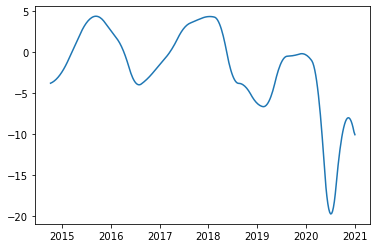

In [23]:
plt.plot(gdp_growth_em_weekly['Argentina'])

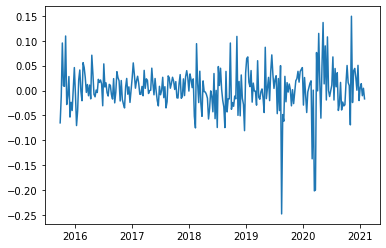

In [25]:
plt.plot(np.exp(equity_rets_w['Argentina'])-1)

In [7]:
gdp_distances = distance_score(gdp_growth_em_weekly)

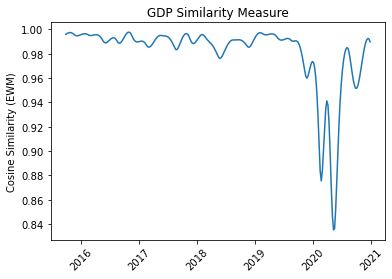

In [8]:
plt.plot(gdp_distances['dist'])
plt.ylabel('Cosine Similarity (EWM)')
plt.title('GDP Similarity Measure')
plt.xticks(rotation=45)
plt.show()

In [9]:
vol_distances = distance_score(equity_vol_w, start=25, method='expanding')

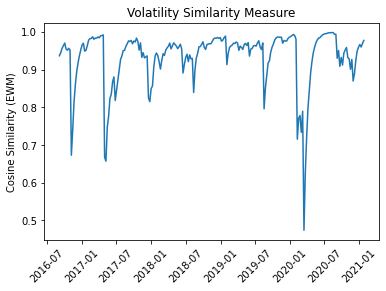

In [10]:
plt.plot(vol_distances['dist'])
plt.ylabel('Cosine Similarity (EWM)')
plt.title('Volatility Similarity Measure')
plt.xticks(rotation=45)
plt.show()

In [11]:
# Combine distance scores
weights = [1/3, 2/3]
# Clean up dates a little bit
gdp_score = gdp_distances[gdp_distances.index>='2016-09-01']
vol_score = vol_distances.iloc[:-4]
# Combine
tot_dist_equity = weights[0] * gdp_score['dist'] + weights[1] * vol_score['dist']

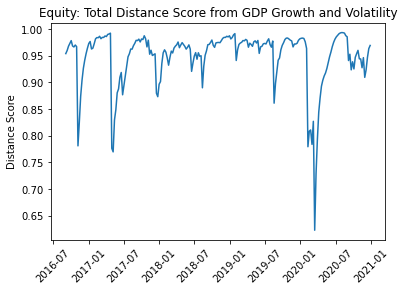

In [12]:
plt.plot(tot_dist_equity)
plt.ylabel('Distance Score')
plt.title('Equity: Total Distance Score from GDP Growth and Volatility')
plt.xticks(rotation=45)
plt.show()

In [13]:
tot_dist_equity = pd.DataFrame(tot_dist_equity)
tot_dist_equity.columns = ['dist']
tot_dist_equity['similarity_score'] = 1/tot_dist_equity['dist']

# transform data
tot_dist_equity['similarity_score_scaled'] = (tot_dist_equity['similarity_score'] -  min(tot_dist_equity['similarity_score']))/ \
                                                (max(tot_dist_equity['similarity_score'])-min(tot_dist_equity['similarity_score']))

# Outputs

<AxesSubplot:>

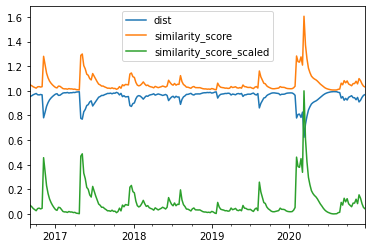

In [14]:
tot_dist_equity.plot()

## Modified Outputs

In [15]:
def distance_score1(df, method='expanding', start=51, window=25):
    '''
    Computes distance score given dataframe of macro data
    + Start: this is the starting month since the beginning of the macro-data 
    as the macro data begins a little before equity returns to allow
    for all scores to be computed / data does not need to be truncated
    + Window: If method = 'rolling', then we use the last 25 weeks' worth of macro data 
    to compute distance score
    Outputs:
    + distances_df: contains distance scores computed from macro data, df
    '''
    estimated_dist_ = []
    dates_ = []
    
    for ii in range(df.shape[0]-start-1):
        current_t = df.iloc[start+ii,:]
        if method == 'expanding':
            previous_t = df.iloc[:start+ii,:]
        else:
            previous_t = df.iloc[window+ii:start+ii,:]

        def calc_distance(current, previous):
            # Find cosine similarity first
            no_mean_current = current - current.mean()
            no_mean_previous = previous - previous.mean()
            cos_sim = np.dot(no_mean_current, no_mean_previous)/(np.linalg.norm(no_mean_current) * np.linalg.norm(no_mean_previous))
            #cos_distance = 1/cos_sim
            return cos_sim

        all_distances = []
        all_dates = []
        for index, row in previous_t.iterrows():
            distance_score = calc_distance(current_t, row)
            all_distances.append(distance_score)
            all_dates.append(row.name)
        all_prev_dist_df = pd.DataFrame(all_distances, index=all_dates)
        all_prev_dist_df.columns = ['Distance']
#         all_prev_dist_df['ewm_dist'] = all_prev_dist_df['Distance'].ewm(alpha=0.3,adjust=False).mean()

        # Take the most recent distances
#         current_t_dist = all_prev_dist_df['ewm_dist'][-1]
        estimated_dist_.append(all_prev_dist_df)
        dates_.append(current_t.name)
    
#     distances_df = pd.DataFrame(estimated_dist_, index=dates_)
#     distances_df.columns = ['dist']
    
    return estimated_dist_, dates_

In [16]:
all_gdp_dist,all_dates = distance_score1(gdp_growth_em_weekly, method='expanding')
for i in range(len(all_dates)):
    all_gdp_dist[i].rename(columns = {'Distance':all_dates[i]},inplace = True)
all_gdp_df = pd.concat(all_gdp_dist,axis=1)

In [17]:
all_vol_dist,all_dates = distance_score1(equity_vol_w, start=25, method='expanding')

for i in range(len(all_dates)):
    all_vol_dist[i].rename(columns = {'Distance':all_dates[i]},inplace = True)
all_vol_df = pd.concat(all_vol_dist,axis=1)

In [18]:
# def inverse_minmax(s):
#     t = s
#     min_t = min(t)
#     max_t = max(t)
#     return (t-min_t)/(max_t-min_t)

def inverse_minmax(s, NewMax = 1.8, NewMin = 0.5):
    t = s
    OldMax = max(t)
    OldMin = min(t)
    OldRange = (OldMax - OldMin)  
    NewRange = (NewMax - NewMin)  
    NewValue = (((t - OldMin) * NewRange) / OldRange) + NewMin
    return NewValue
    

all_gdp_df = all_gdp_df.apply(inverse_minmax,axis=0)
all_vol_df = all_vol_df.apply(inverse_minmax,axis=0)

In [19]:
all_gdp_df.to_pickle('../Outputs/macroeconomics/gdp_distance.pickle')
all_vol_df.to_pickle('../Outputs/macroeconomics/vol_distance.pickle')